## How to find the best connectivity model for each cerebellar region across datasets? 
We start from a simple hierarchical model 

* Global connectivity model g=$N(0,sigma_g)$ 
* Data set specific variances and covariances $N(0,D)$ where D is the full dataset x dataset covariance matrix
* For each dataset, we generate $n_i$ subjects with $N(0,\sigma^2_{subject,i})$ noise for the $ith dataset. 

Given some data and known covariance structure, what is the best estimator of g?  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PcmPy as pcm

In [2]:
def generate_data(sigma2_g,dataset_cov, dataset_size,subject_var,P=100):
    """Create a random data set with a given hierarchical covariance structure."""
    g=np.random.normal(0,sigma2_g,size=(P,))
    # generate dataset patterns
    n_dataset = len(dataset_size)
    D = np.random.normal(0, 1, (n_dataset, P)) 
    C = np.linalg.cholesky(dataset_cov)
    D = C @ D
    data = []   
    for i in range(n_dataset):
        # generate dataset
        d = np.random.normal(0,np.sqrt(subject_var[i]),size=(dataset_size[i],P)) + D[i] + g 
        data.append(d)
    data = np.concatenate(data, axis=0)
    return data,g,D

def get_indicator_matrix(dataset_size):
    dataset = [np.ones((dataset_size[i],))*i for i in range(len(dataset_size))]    
    dataset = np.concatenate(dataset, axis=0)
    X = pcm.matrix.indicator(dataset)
    return X

def predict_covariance(sigma2_g,dataset_cov,dataset_size,subject_var):
    """Predict the covariance matrix of all subejcts from the variances"""
    X = get_indicator_matrix(dataset_size)
    Noise_var = np.diag (X@np.array(subject_var))
    # create covariance matrix
    COV = X @ dataset_cov @ X.T + Noise_var + sigma2_g
    return COV

def get_integration_weights(methods, sigma2_g,dataset_cov,dataset_size,subject_var):
    Xd = get_indicator_matrix(dataset_size)
    N = Xd.shape[0]
    X1 = np.ones((N,1))     
    # Make weight vectors 
    W = np.zeros((len(methods),N)) 
    for i,m in enumerate(methods):
        if m == 'mean':
            W[i] = np.linalg.pinv(X1)
        if m == 'datasetmean':
            W[i] = np.mean(np.linalg.pinv(Xd),axis=0)
        if m == 'GLS':
            COV = predict_covariance(sigma2_g,dataset_cov,dataset_size,subject_var)
            iC = np.linalg.inv(COV)
            W[i]= np.linalg.inv(X1.T @ iC @ X1) @ X1.T @ iC
    return W

def simulate_estimation(sigma2_g,dataset_cov,dataset_size,subject_var, P=100,n_sim=1000):
    """Simulate the estimation of the covariance matrix."""
    # generate data
    results = pd.DataFrame()
    methods =['mean','datasetmean','GLS']
    W = get_integration_weights(methods, sigma2_g,dataset_cov,dataset_size,subject_var)
    for i in range(n_sim):
        data,g,D = generate_data(sigma2_g,dataset_cov, dataset_size,subject_var,P=P)
        # Get estimators and evaluate 
        for i,m in enumerate(methods):
            g_hat = W[i]@data
            r = {'method':m,
                 'R2':np.sum((g_hat-g)**2)/np.sum((g)**2),
                 'R':np.corrcoef(g_hat,g)[0,1]}
            results = pd.concat([results,pd.DataFrame(r,index=[0])],ignore_index=True)
    return results

def simulate_estimation_with_data_loso(sigma2_g, dataset_cov, dataset_size, subject_var, P=100, n_sim=1000):
    """Simulate the estimation of the covariance matrix with leave-one-subject-out."""
    results = pd.DataFrame()
    methods = ['mean', 'datasetmean', 'GLS']
    for sim in range(n_sim):
        data, g, D = generate_data(sigma2_g, dataset_cov, dataset_size, subject_var, P=P)
        total_subjects = sum(dataset_size)
        for sub in range(total_subjects):
            # Remove the subject `sub` from the data
            data_loso = np.delete(data, sub, axis=0)
            d = next(i for i, size in enumerate(dataset_size) if sub < sum(dataset_size[:i + 1]))
            dataset_size_loso = dataset_size.copy()
            dataset_size_loso[d] -= 1

            # Generate weights for leave-one-subject-out
            W = get_integration_weights(methods, sigma2_g, dataset_cov, dataset_size_loso, subject_var)

            # Get estimators and evaluate
            for i, m in enumerate(methods):
                g_hat = W[i] @ data_loso
                R2 = np.sum((g_hat - data[sub]) ** 2) / np.sum(data[sub] ** 2)
                R = np.corrcoef(g_hat, data[sub])[0, 1]
                r = {
                    'sub': sub + 1,
                    'dataset': d,
                    'method': m,
                    'R2': R2,
                    'R': R
                }
                results = pd.concat([results, pd.DataFrame(r, index=[0])], ignore_index=True)
    return results

def simulate_estimation_with_data_lodo(sigma2_g,dataset_cov,dataset_size,subject_var, P=100,n_sim=1000):
    """Simulate the estimation of the covariance matrix."""
    # generate data
    results = pd.DataFrame()
    methods =['mean','datasetmean','GLS']
    for i in range(n_sim):
        data,g,D = generate_data(sigma2_g, dataset_cov, dataset_size, subject_var, P=P)
        for d in range(len(dataset_size)):
            # Remove the dataset d from all inputs
            start_idx = sum(dataset_size[:d])
            end_idx = start_idx + dataset_size[d]
            data_lodo = np.delete(data, np.arange(start_idx, end_idx), axis=0)
            dataset_size_lodo = dataset_size[:d] + dataset_size[d+1:]
            subject_var_lodo = subject_var[:d] + subject_var[d+1:]
            dataset_cov_lodo = np.delete(np.delete(dataset_cov, d, axis=0), d, axis=1)

            # Generate weights for leave-one-dataset-out
            W = get_integration_weights(methods, sigma2_g, dataset_cov_lodo, dataset_size_lodo, subject_var_lodo)
        
            # Get estimators and evaluate 
            for i,m in enumerate(methods):
                g_hat = W[i]@data_lodo
                for i in range(start_idx, end_idx):
                    R2 = np.sum((g_hat-data[i])**2)/np.sum((data[i])**2)
                    R = np.corrcoef(g_hat,data[i])[0,1]
                    r = {
                        'sub': i+1,
                        'method':m,
                        'dataset':d,
                        'R2':R2,
                        'R':R}
                    results = pd.concat([results,pd.DataFrame(r,index=[0])],ignore_index=True)
    return results

In [3]:

# Get the overall group pattern 
sigma2_g = 1
size = [5,30,10,5,10]
var = [3,2,1.5,1,2]

# Coavariance matrix across the datasets
dataset_cov = np.eye(5)
dataset_cov[0,1] = 0.5
dataset_cov[1,0] = 0.5
dataset_cov[1,2] = 0.4
dataset_cov[2,1] = 0.4
dataset_cov[0,2] = 0.3
dataset_cov[2,0] = 0.3
dataset_cov[3,2] = 0.1
dataset_cov[2,3] = 0.1
dataset_cov[4,3] = 0.6
dataset_cov[3,4] = 0.6
dataset_cov[2,4] = 0.05
dataset_cov[4,2] = 0.05

data,g,D = generate_data(sigma2_g, dataset_cov, dataset_size=size,subject_var=var,P=200)
COV = predict_covariance(sigma2_g,dataset_cov, dataset_size=size,subject_var=var)

Sum of GLS_weights for each dataset: [0.14, 0.23, 0.2, 0.2, 0.22]


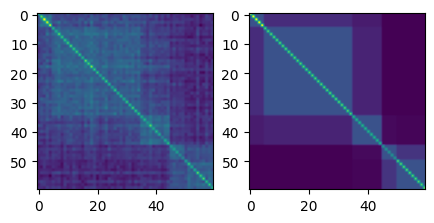

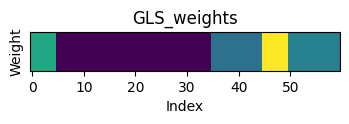

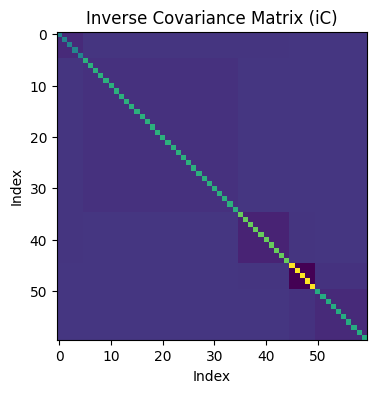

In [4]:
plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(data @ data.T)
plt.subplot(1,2,2)
plt.imshow(COV)

iC = np.linalg.inv(COV)
GLS_weights = np.sum(iC, axis=0) / np.sum(iC)

# Plot the GLS_weights separately
plt.figure(figsize=(4, 0.5))
plt.imshow(GLS_weights[np.newaxis, :], aspect='auto')
plt.yticks([])
plt.title('GLS_weights')
plt.xlabel('Index')
plt.ylabel('Weight')

plt.figure(figsize=(4, 4))
plt.imshow(iC, aspect='auto')
plt.title('Inverse Covariance Matrix (iC)')
plt.xlabel('Index')
plt.ylabel('Index')

# Calculate the sum of GLS_weights for each dataset
dataset_sums = []
start_idx = 0
for dataset_size in size:
    end_idx = start_idx + dataset_size
    dataset_sums.append(np.sum(GLS_weights[start_idx:end_idx]))
    start_idx = end_idx

# Print the sums
print("Sum of GLS_weights for each dataset:", [round(s, 2) for s in dataset_sums])

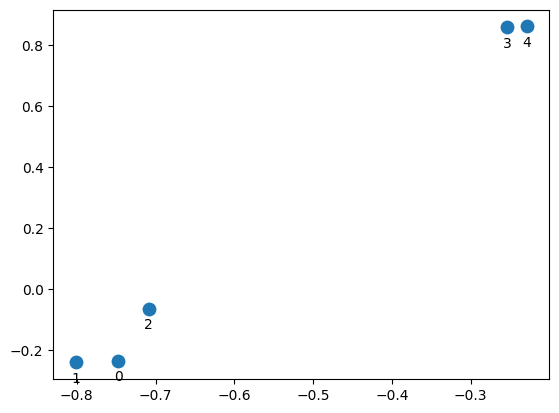

In [5]:
W, _ = pcm.util.classical_mds(dataset_cov)
plt.scatter(W[:, 0], W[:, 1], s=80)
for i in range(len(size)):
    plt.annotate(i, (W[i, 0], W[i, 1]-0.03), fontsize=10, ha='center', va='top')

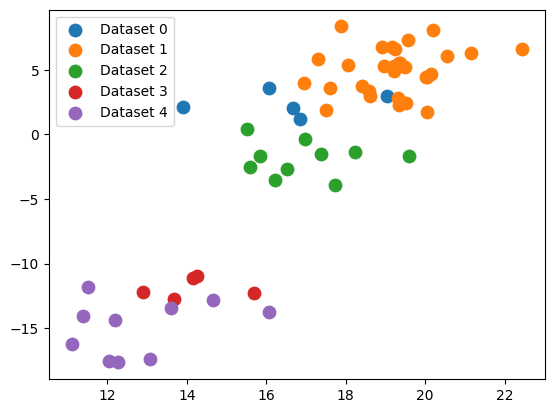

In [6]:
W, _ = pcm.util.classical_mds(data @ data.T)
dataset_labels = ["0", "1", "2", "3", "4"]
for idx, label in enumerate(dataset_labels):
    start_idx = sum(size[:idx])
    end_idx = start_idx + size[idx]
    plt.scatter(W[start_idx:end_idx, 0], W[start_idx:end_idx, 1], s=80, color=plt.cm.tab10(idx), label=f'Dataset {label}')
plt.legend()

Text(0.5, 1.0, 'Integration weights')

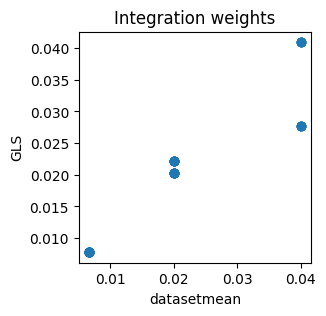

In [7]:
# Look at the integration weights of dataset_mean and GLS
methods = ['datasetmean','GLS']
W = get_integration_weights(methods, sigma2_g,dataset_cov, dataset_size=size,subject_var=var)
plt.figure(figsize=(3,3))
plt.scatter(W[0],W[1])
plt.xlabel('datasetmean')
plt.ylabel('GLS')
plt.title('Integration weights')

Text(0.5, 1.0, 'R')

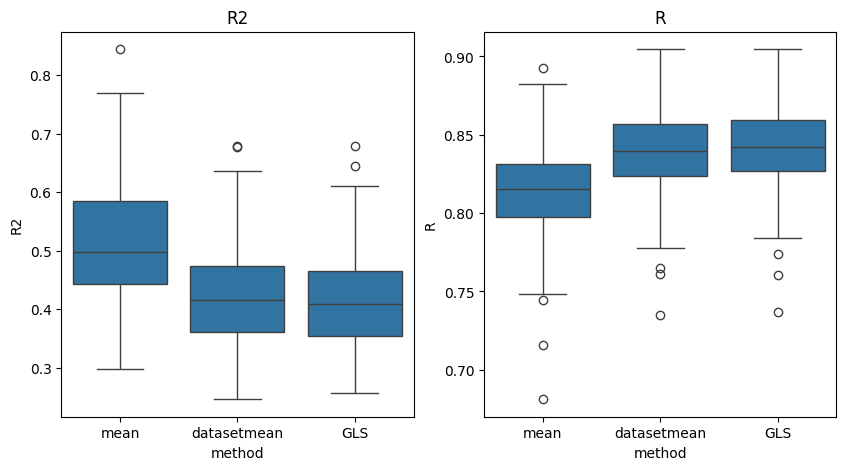

In [8]:
R = simulate_estimation(sigma2_g,dataset_cov,dataset_size=size,subject_var=var, P=100,n_sim=200)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x='method',y='R2',data=R)
plt.title('R2')
plt.subplot(1,2,2)
sns.boxplot(x='method',y='R',data=R)
plt.title('R')

### LOSO

Text(0.5, 1.0, 'R')

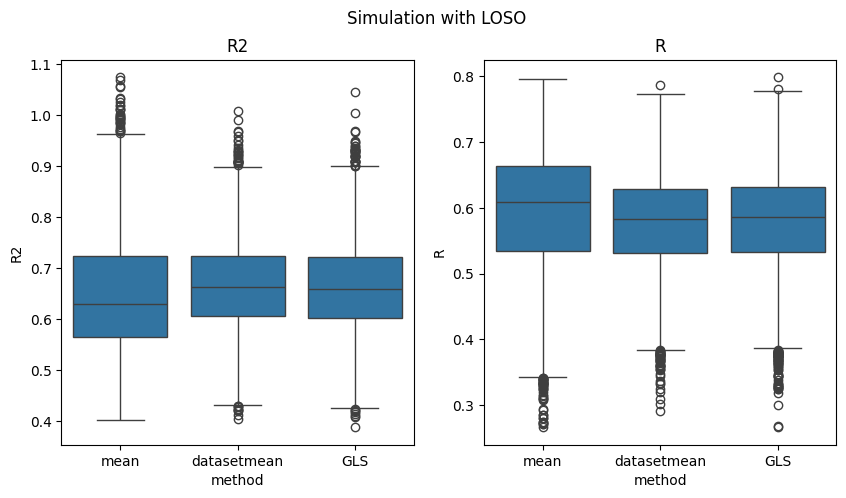

In [9]:
# simulate on loso
R_loso = simulate_estimation_with_data_loso(sigma2_g,dataset_cov,dataset_size=size,subject_var=var, P=100,n_sim=100)
plt.figure(figsize=(10,5))
plt.suptitle('Simulation with LOSO')
plt.subplot(1,2,1)
sns.boxplot(x='method',y='R2',data=R_loso)
plt.title('R2')
plt.subplot(1,2,2)
sns.boxplot(x='method',y='R',data=R_loso)
plt.title('R')

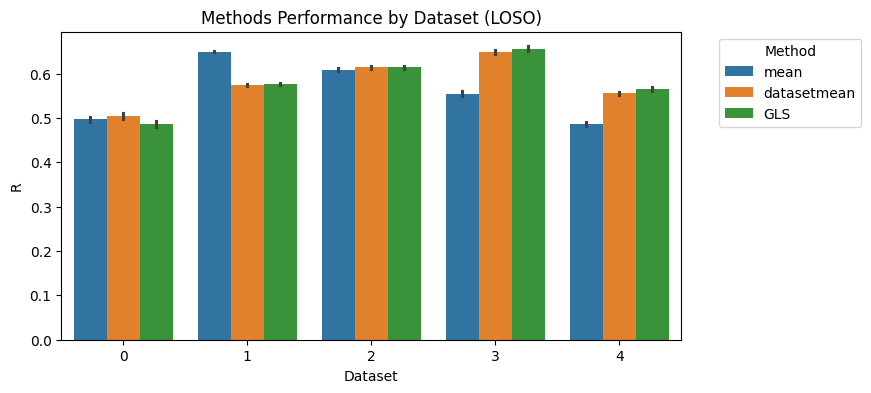

In [10]:
plt.figure(figsize=(8, 4))
sns.barplot(x='dataset', y='R', hue='method', data=R_loso)
plt.title('Methods Performance by Dataset (LOSO)')
plt.xlabel('Dataset')
plt.ylabel('R')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

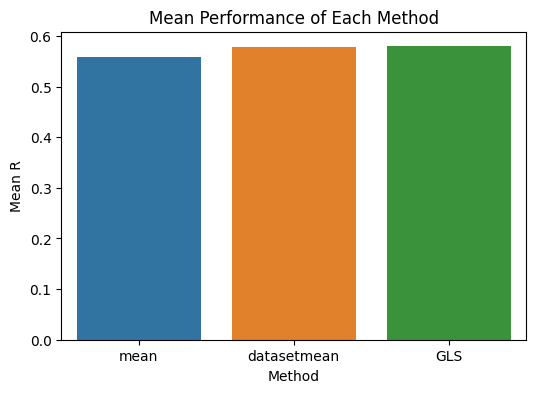

In [11]:
# Calculate the mean R value for each method across datasets
dataset_means = R_loso.groupby(['dataset', 'method'])['R'].mean().reset_index()
mean_performance = dataset_means.groupby('method')['R'].mean().reset_index()
mean_performance = mean_performance.set_index('method').reindex(['mean', 'datasetmean', 'GLS']).reset_index()

# Plot the mean performance
plt.figure(figsize=(6, 4))
sns.barplot(x='method', y='R', data=mean_performance, hue='method')
plt.title('Mean Performance of Each Method')
plt.xlabel('Method')
plt.ylabel('Mean R')
plt.show()

### LODO

Text(0.5, 1.0, 'R')

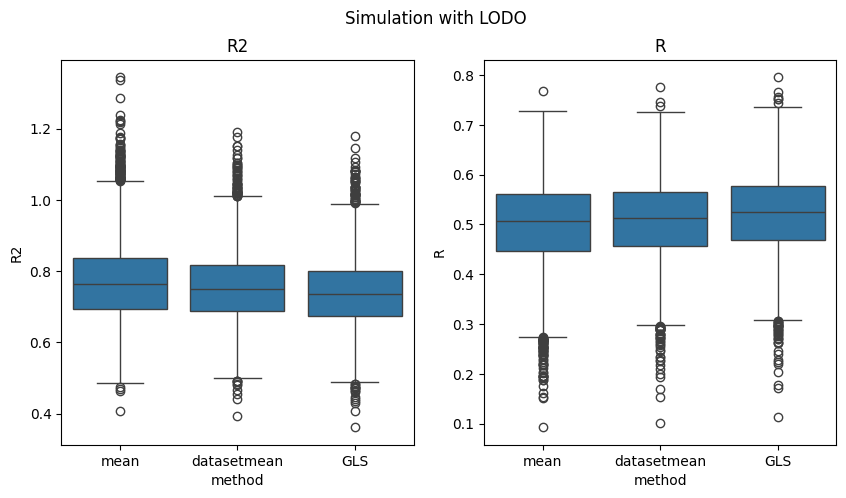

In [12]:
# simulate on lodo
R_lodo = simulate_estimation_with_data_lodo(sigma2_g,dataset_cov,dataset_size=size,subject_var=var, P=100,n_sim=100)
plt.figure(figsize=(10,5))
plt.suptitle('Simulation with LODO')
plt.subplot(1,2,1)
sns.boxplot(x='method',y='R2',data=R_lodo)
plt.title('R2')
plt.subplot(1,2,2)
sns.boxplot(x='method',y='R',data=R_lodo)
plt.title('R')

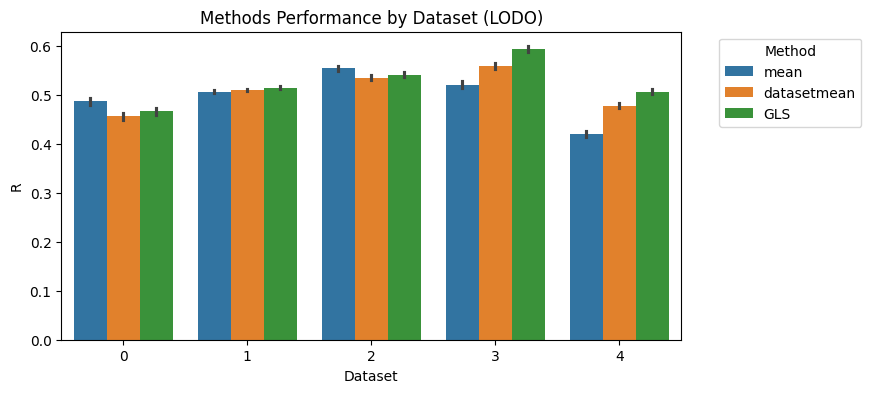

In [13]:
plt.figure(figsize=(8, 4))
sns.barplot(x='dataset', y='R', hue='method', data=R_lodo)
plt.title('Methods Performance by Dataset (LODO)')
plt.xlabel('Dataset')
plt.ylabel('R')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

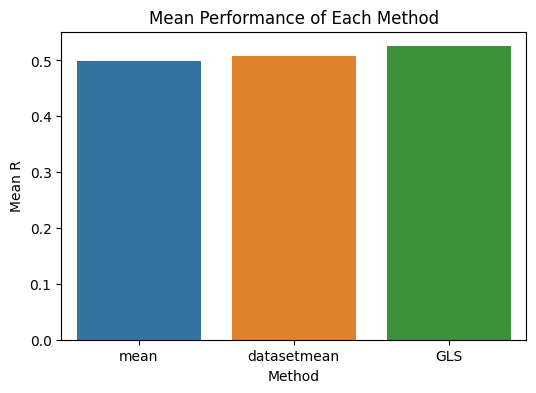

In [14]:
# Calculate the mean R value for each method across datasets
dataset_means = R_lodo.groupby(['dataset', 'method'])['R'].mean().reset_index()
mean_performance = dataset_means.groupby('method')['R'].mean().reset_index()
mean_performance = mean_performance.set_index('method').reindex(['mean', 'datasetmean', 'GLS']).reset_index()

# Plot the mean performance
plt.figure(figsize=(6, 4))
sns.barplot(x='method', y='R', data=mean_performance, hue='method')
plt.title('Mean Performance of Each Method')
plt.xlabel('Method')
plt.ylabel('Mean R')
plt.show()

### Only one unique dataset

Text(0.5, 1.0, 'R')

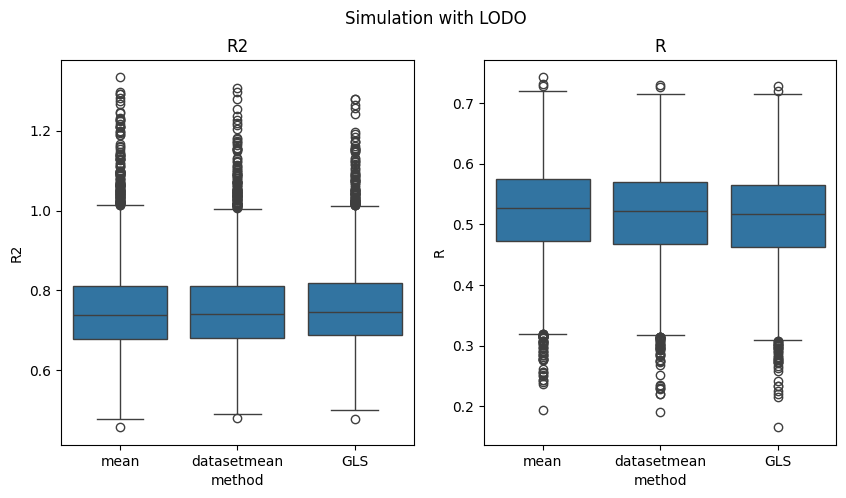

In [15]:
# simulate on lodo
R_lodo_2 = simulate_estimation_with_data_lodo(sigma2_g,dataset_cov[:-1, :-1],dataset_size=size[:-1],subject_var=var[:-1], P=100,n_sim=100)
plt.figure(figsize=(10,5))
plt.suptitle('Simulation with LODO')
plt.subplot(1,2,1)
sns.boxplot(x='method',y='R2',data=R_lodo_2)
plt.title('R2')
plt.subplot(1,2,2)
sns.boxplot(x='method',y='R',data=R_lodo_2)
plt.title('R')

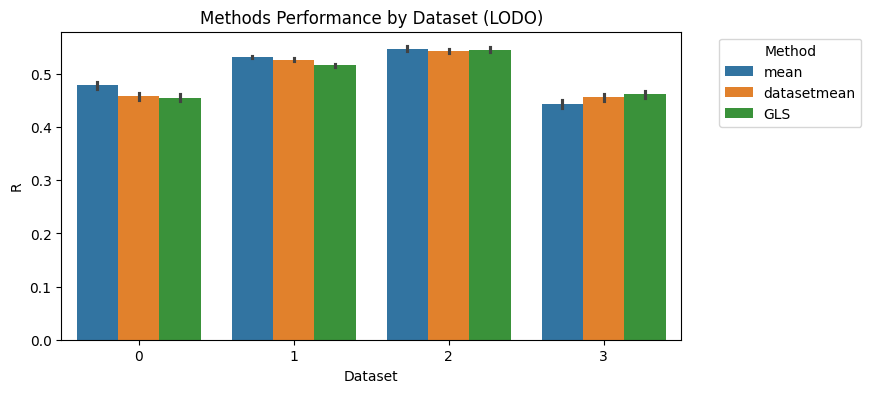

In [16]:
plt.figure(figsize=(8, 4))
sns.barplot(x='dataset', y='R', hue='method', data=R_lodo_2)
plt.title('Methods Performance by Dataset (LODO)')
plt.xlabel('Dataset')
plt.ylabel('R')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

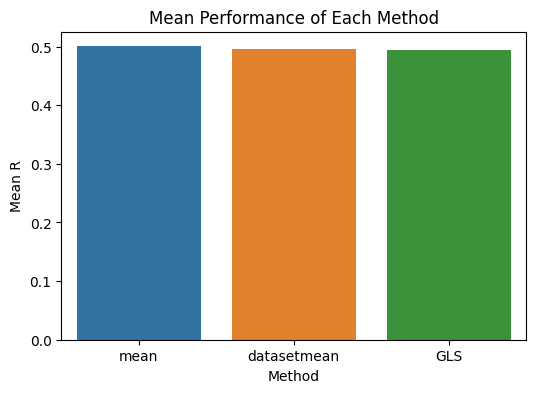

In [17]:
# Calculate the mean R value for each method across datasets
dataset_means = R_lodo_2.groupby(['dataset', 'method'])['R'].mean().reset_index()
mean_performance = dataset_means.groupby('method')['R'].mean().reset_index()
mean_performance = mean_performance.set_index('method').reindex(['mean', 'datasetmean', 'GLS']).reset_index()

# Plot the mean performance
plt.figure(figsize=(6, 4))
sns.barplot(x='method', y='R', data=mean_performance, hue='method')
plt.title('Mean Performance of Each Method')
plt.xlabel('Method')
plt.ylabel('Mean R')
plt.show()

### LOSO on One Unique dataset

Text(0.5, 1.0, 'R')

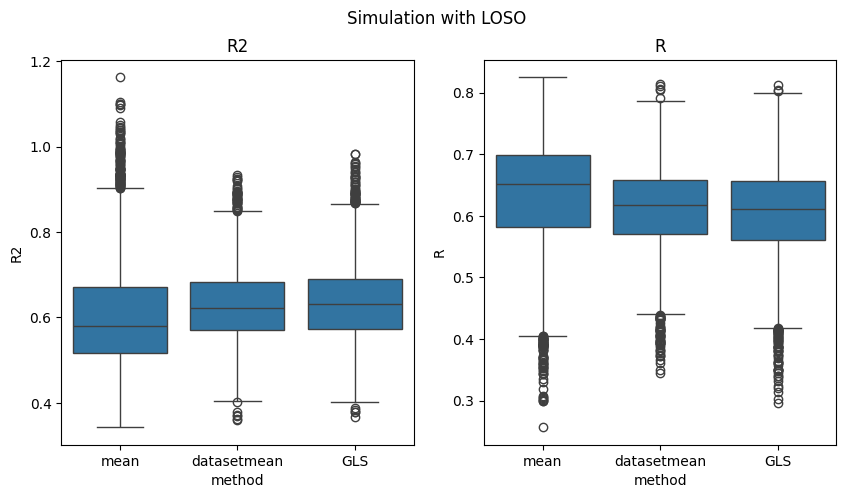

In [22]:
# simulate on lodo
R_loso_2 = simulate_estimation_with_data_loso(sigma2_g,dataset_cov[:-1, :-1],dataset_size=size[:-1],subject_var=var[:-1], P=100,n_sim=100)
plt.figure(figsize=(10,5))
plt.suptitle('Simulation with LOSO')
plt.subplot(1,2,1)
sns.boxplot(x='method',y='R2',data=R_loso_2)
plt.title('R2')
plt.subplot(1,2,2)
sns.boxplot(x='method',y='R',data=R_loso_2)
plt.title('R')

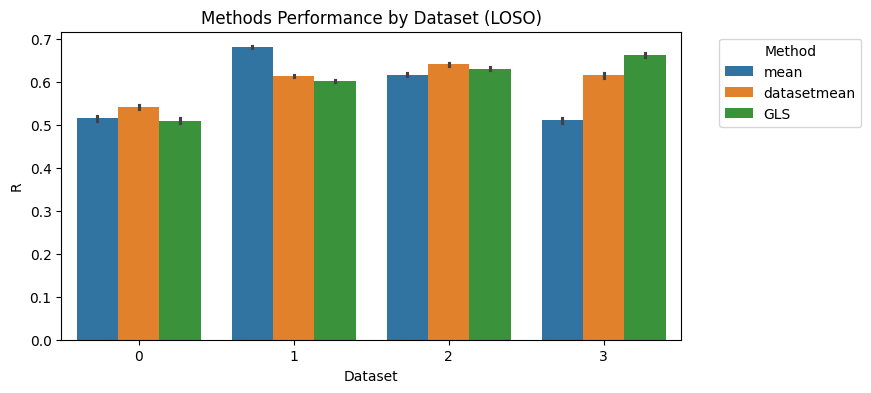

In [23]:
plt.figure(figsize=(8, 4))
sns.barplot(x='dataset', y='R', hue='method', data=R_loso_2)
plt.title('Methods Performance by Dataset (LOSO)')
plt.xlabel('Dataset')
plt.ylabel('R')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

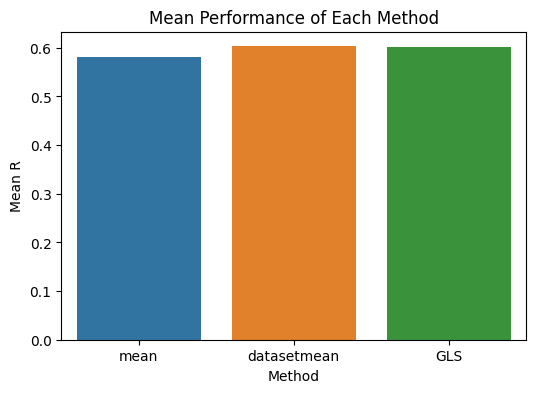

In [24]:
# Calculate the mean R value for each method across datasets
dataset_means = R_loso_2.groupby(['dataset', 'method'])['R'].mean().reset_index()
mean_performance = dataset_means.groupby('method')['R'].mean().reset_index()
mean_performance = mean_performance.set_index('method').reindex(['mean', 'datasetmean', 'GLS']).reset_index()

# Plot the mean performance
plt.figure(figsize=(6, 4))
sns.barplot(x='method', y='R', data=mean_performance, hue='method')
plt.title('Mean Performance of Each Method')
plt.xlabel('Method')
plt.ylabel('Mean R')
plt.show()